# Image Features and Measuring Image Quality

The quality of the advertisement image significantly affects the demand volume on an item. For both advertisers and Avito, it is important to use authentic high quality images. Due to this observation and the importance of 'image_top_1' feature, we extracted relevant image features to measure the <b><i>Image Quality<i></b>:

![Alt](https://i.imgur.com/84TEdoa.png)

### 1. Feature Extraction
### 1.1 Dimensions: Is the image too large or small?
1.1.1 Wigth of the image<br/>
1.1.2 Height of the image<br/>
1.1.3 Size of the image
### 1.2. Sharpness: Is the image too blurry?
1.2.1 Image Sharpness score
### 1.3. Luminance: Is the image too bright?
1.3.1 Image Luminance score
### 1.4. Colors: Does the image has many colors?
1.4.1 Image Colorfulness score<br/>
1.4.2 Dominant color of the image<br/>
1.4.3 Average color of the image
### 1.5. Luminance: Is the image too bright?
1.5.1 Image Luminance score
### 1.6. Keypoints: How many 'interesting' points in the image?
1.6.1 Image Keypoints
### 1.7. Classification: How good the image can be classified?
1.7.1 Resnet50 score<br/>
1.7.2 Xception score<br/>
1.7.3 Inception score<br/>
1.7.4 Image Confidence score
***
### 2. Feature Engineering
2.1 Correlations<br/>
2.2 Power Users
***
### 3. Conclusion
***

#### Imports:

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from scipy.stats import itemfreq
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
import keras.applications.resnet50 as resnet50
import keras.applications.xception as xception
import keras.applications.inception_v3 as inception_v3
resnet_model = resnet50.ResNet50(weights='imagenet')
inception_model = inception_v3.InceptionV3(weights='imagenet')
xception_model = xception.Xception(weights='imagenet')

/Users/ilaif/.virtualenvs/ds/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Helper functions:

In [2]:
def get_dominant_color(img):
    arr = np.float32(img)
    pixels = arr.reshape((-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)

    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(img.shape)

    dominant_color = palette[np.argmax(itemfreq(labels)[:, -1])]
    return dominant_color


def get_colorfulness(img):
    # split the image into its respective RGB components
    (B, G, R) = cv2.split(img.astype("float"))
    # compute rg = R - G
    rg = np.absolute(R - G)
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)


def get_luminance(img):
    # split the image into its respective RGB components
    (B, G, R) = cv2.split(img.astype("float"))
    lum = (0.2126*R + 0.7152*G + 0.0722*B)
    return sum(lum.flatten())/10000


def get_sharpness(image):
    """compute the Laplacian of the image and then return the focus
    measure, which is simply the variance of the Laplacian """
    return cv2.Laplacian(image, cv2.CV_64F).var()


def get_keypoints(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray,None) 
    return len(kp)


def get_data_from_image(dat, show_img = False):
    if show_img:
        plt.imshow(dat[0])
    cv_img = cv2.imread(dat[2])
    img_size = [cv_img.shape[0]*cv_img.shape[1], cv_img.shape[1], cv_img.shape[0]]    # image dimensions
    (means, stds) = cv2.meanStdDev(cv_img)
    average_color = [int(round(means[0][0])), int(round(means[1][0])), int(round(means[2][0]))]
    dominant_color = get_dominant_color(cv_img)    # dominant colors
    dominant_colors = [dominant_color[0], dominant_color[1], dominant_color[2]]
    color_stats = np.concatenate([means, stds]).flatten()
    gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)   # image grayscale pixels
    sharpness = get_sharpness(gray)   # sharpness score
    colorfulness = get_colorfulness(cv_img)   # colorfulness score
    luminance = get_luminance(cv_img)         # luminance score
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray,None)    # keypoints
    # image classification
    scores = []
    for model in dat[1]:
        preds = []
        for pred in model[1]:
            preds.append((pred[1], pred[2]))
        scores.append(preds)
    confidence = (scores[0][0][1] + scores[1][0][1] + scores[2][0][1]) / 3    # image confidence
    data = img_size + [sharpness] + [luminance] + [colorfulness] + [len(kp)] + [confidence] + [dominant_color] + dominant_colors + [average_color] + color_stats.tolist() + scores
    return data

## Image Classification with Deep Learning
<a href="https://keras.io/applications/">Keras</a> provides pre-trained deep learning models to classify our images. The assumption here is that the image classification accuracy score will reflect how clear it is for a human to identify it, and affect the chance of buying it.
We extracted the data from three pre-trained deep learning models - ResNet50, InceptionV3 and Xception. From each model, we got the top-3 scores with probabilities, and averaged them to a feature named 'img_confidence'. This feature might reflect the probabilty of a human to identify the details in the image.

In [3]:
def image_classify(model, pak, img, top_n=3):
    """Classify image and return top matches."""
    target_size = (224, 224)
    if img.size != target_size:
        img = img.resize(target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = pak.preprocess_input(x)
    preds = model.predict(x)
    return pak.decode_predictions(preds, top=top_n)


def plot_preds(img, preds_arr):
    """Plot image and its prediction."""
    sns.set_color_codes('pastel')
    f, axarr = plt.subplots(1, len(preds_arr) + 1, figsize=(20, 5))
    axarr[0].imshow(img)
    axarr[0].axis('off')
    for i in range(len(preds_arr)):
        _, x_label, y_label = zip(*(preds_arr[i][1]))
        plt.subplot(1, len(preds_arr) + 1, i + 2)
        ax = sns.barplot(np.array(y_label), np.array(x_label))
        plt.xlim(0, 1)
        ax.set()
        plt.xlabel(preds_arr[i][0])
    plt.show()
    

def classify_and_plot(image_path, plot = False):
    """Classify an image with different models.
    """
    img = Image.open(image_path)
    resnet_preds = image_classify(resnet_model, resnet50, img)
    xception_preds = image_classify(xception_model, xception, img)
    inception_preds = image_classify(inception_model, inception_v3, img)
    
    preds_arr = [('Resnet50', resnet_preds[0]), ('xception', xception_preds[0]), ('Inception', inception_preds[0])]
    if plot:
        plot_preds(img, preds_arr)
    return (img, preds_arr, image_path)

## Let's see some examples:

[1] Define the data paths:

In [4]:
DATA_PATH = "/home/u14303/Avito"
IMG_PATH = DATA_PATH + "/train_jpg_0"
image_files = [x.path for x in os.scandir(IMG_PATH)]
image_files = [image_files[3]] + [image_files[9]] + [image_files[17]] + [image_files[20]]

[2] Extract all the features from the selected images:

In [5]:
df = pd.DataFrame(columns = ['img_size', 'img_size_x', 'img_size_y', 'img_sharpness', 'img_luminance', 'img_colorfulness', 'img_keypoints', 'img_confidence', 'img_dominant_color', 'img_dominant_blue', 'img_dominant_green', 'img_dominant_red', 'img_avg_color', 'img_blue_avg', 'img_green_avg', 'img_red_avg', 'img_blue_std', 'img_green_std', 'img_red_std', 'Resnet50_score', 'xception_score', 'Inception_score'])
for i in range(0, len(image_files)):
    img_id = os.path.basename(image_files[i][:-4])
    dat = classify_and_plot(image_files[i])
    row = get_data_from_image(dat, show_img = False)
    df.loc[df.shape[0]] = row
df = df.drop(['img_dominant_blue', 'img_dominant_green', 'img_dominant_red', 'img_blue_avg', 'img_green_avg', 'img_red_avg', 'img_blue_std', 'img_green_std', 'img_red_std', 'Resnet50_score', 'xception_score', 'Inception_score'], axis=1)

Now let's show the results:

### Example 1:

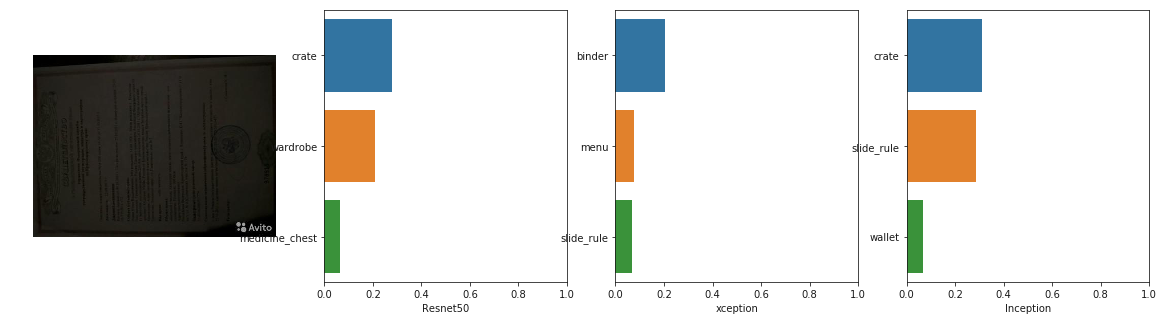

img_size                    172800
img_size_x                     480
img_size_y                     360
img_sharpness              65.5039
img_luminance              508.862
img_colorfulness           4.47452
img_keypoints                   46
img_confidence            0.264983
img_dominant_color    [24, 30, 32]
img_avg_color         [24, 29, 32]
Name: 0, dtype: object

In [6]:
classify_and_plot(image_files[0], plot = True)
df.iloc[0]

We can observe that this image is too blurry, dark, and not clear. Therefore, the sharpness, luminance, colorfulness score is low. In addition, we can see that the classification is also with low probabilities in the 3 models, so the image confidence is also low.

### Example 2:

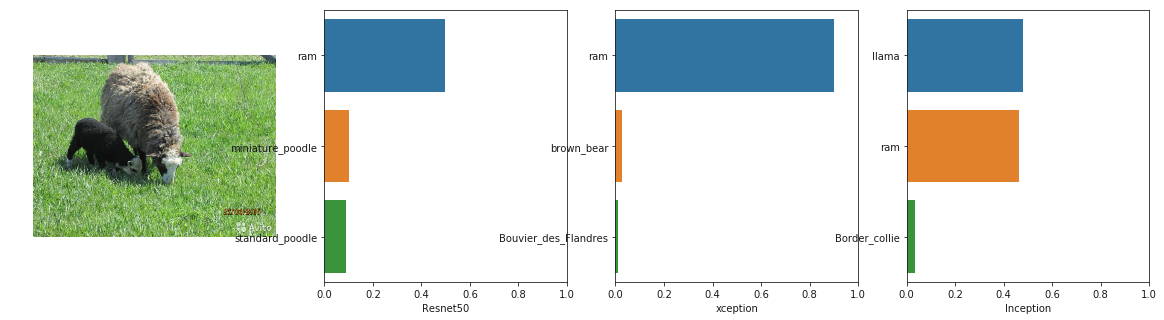

img_size                       172800
img_size_x                        480
img_size_y                        360
img_sharpness                 1922.07
img_luminance                 2432.78
img_colorfulness              48.3063
img_keypoints                    2181
img_confidence               0.626407
img_dominant_color    [108, 181, 140]
img_avg_color          [90, 153, 117]
Name: 1, dtype: object

In [7]:
classify_and_plot(image_files[1], plot = True)
df.iloc[1]

Here the image is sharp, not dark, and has many colors. In addition, all 3 models managed to classify it. 

### Example 3:

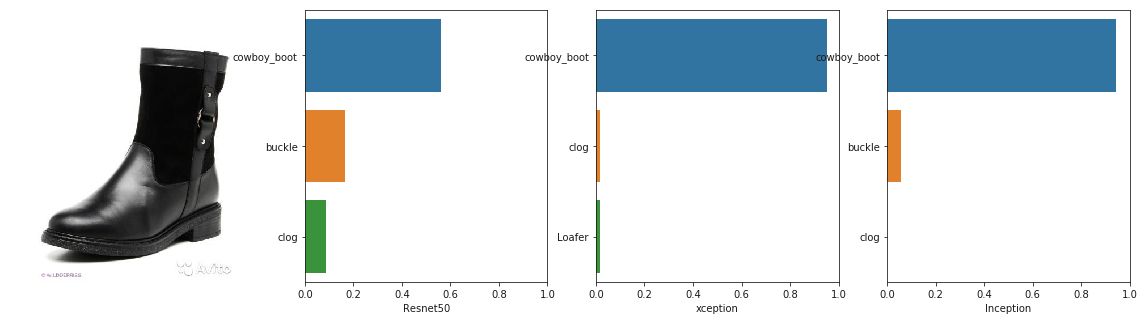

img_size                       172800
img_size_x                        360
img_size_y                        480
img_sharpness                 360.226
img_luminance                 2969.34
img_colorfulness              1.49996
img_keypoints                     165
img_confidence               0.819103
img_dominant_color    [254, 254, 254]
img_avg_color         [172, 172, 172]
Name: 2, dtype: object

In [8]:
classify_and_plot(image_files[2], plot = True)
df.iloc[2]

Here the image is also sharp, got many white areas, and has less colors. In addition, all 3 models managed to classify it better than the last 2 images, so the confidence is the highest.
***

### Example 4:

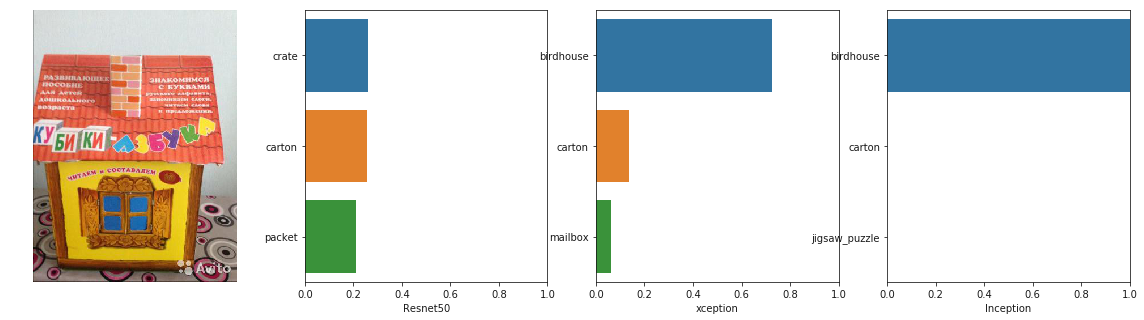

img_size                       172800
img_size_x                        360
img_size_y                        480
img_sharpness                 674.513
img_luminance                  2559.8
img_colorfulness              95.4375
img_keypoints                    1733
img_confidence               0.661983
img_dominant_color    [210, 213, 217]
img_avg_color         [108, 141, 187]
Name: 3, dtype: object

In [9]:
classify_and_plot(image_files[3], plot = True)
df.iloc[3]

***

## Feature Engineering
Now let's see if we can learn something from these features.

In [10]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), parse_dates=['activation_date'])
train_img_features = pd.read_csv(os.path.join(HELPER_DATA_PATH, 'train_img_features.zip'))

In [11]:
train.head(10)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797
5,51e0962387f7,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Авто люлька,В хорошем состоянии,1300.0,9,2017-03-28,Private,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,796.0,0.80323
6,c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,NaN,NaN,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,11000.0,125,2017-03-23,Private,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.0,0.00000
7,6b71309d6a8a,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Джинсы,26,Бойфренды colins,Бойфренды в хорошем состоянии.,500.0,61,2017-03-25,Private,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,567.0,0.80323
8,c5b969cb63a2,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,> 50 (XXL),Платье,54 раз мер очень удобное,500.0,85,2017-03-17,Private,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,415.0,0.00000
9,b1570962e68c,f9e8f831d94c,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,25,Полу ботиночки замш натур.Бамбини,По стельке 15.5см мерить приокский район. Цвет...,400.0,136,2017-03-22,Company,54fb8521135fda77a860bfd2fac6bf46867ab7c06796e3...,46.0,0.00000


In [12]:
train_img_features.head(10)

,img_id,img_size,img_size_x,img_size_y,img_sharpness,img_luminance,img_colorfulness,img_dominant_color,img_dominant_blue,img_dominant_green,img_dominant_red,img_color_avg,img_blue_avg,img_green_avg,img_red_avg,img_blue_std,img_green_std,img_red_std,img_confidence
0,00004ab3d9747e37917f4a63a94d9fd2bed3c11c944e90...,129600,360,360,640.977508,2256.981759,35.843903,[254 254 254],254,254,254,"[182, 176, 165]",181.913642,175.975988,165.369877,88.558379,93.138895,102.329899,0.537303
1,00006dbf726b061250fbdd755ce3aa0f199be5ce2e144f...,172800,360,480,264.865910,1504.661487,28.633844,[ 74 95 104],74,95,104,"[72, 87, 92]",72.393536,87.065162,92.095486,42.964247,45.893539,48.518613,0.522382
2,00007bcbecea48765994804519e2e4e2354eb1e4636771...,172800,360,480,477.373926,1987.906912,43.179691,[19 35 72],19,35,72,"[96, 112, 132]",95.902726,111.969699,131.872078,80.787713,76.248765,61.079278,0.459112
3,0000a9c3f3e373ee1b8069ca1370ad71a8ce399f0e6175...,172800,480,360,65.503883,508.862134,4.474525,[30 35 38],30,35,38,"[24, 29, 32]",23.841748,29.403142,31.503003,10.741228,10.866127,11.341529,0.264982
4,00016e49eac032cb5c5b1611f87a860f14253234f3d6d7...,172800,360,480,841.013424,2078.998037,29.951734,[172 157 171],172,157,171,"[130, 117, 129]",129.700532,116.838519,128.810440,63.768069,63.397314,64.897819,0.539084
5,0001a23e452b0c1a006d04c444fed0d82a164175817c09...,172800,360,480,170.511577,828.432558,12.962352,[4 9 2],4,9,2,"[43, 49, 45]",43.157176,49.418866,44.597263,72.516860,71.163693,72.391195,0.263808
6,0001d531a6cdf8b2840ee5cbde6a3bb3307c55a462cbfe...,172800,480,360,1116.578440,2454.053346,31.460860,[147 143 140],147,143,140,"[159, 143, 135]",158.674514,142.532384,134.626128,56.334304,56.264408,54.952275,0.497491
7,00020261e70f5e8be5acef1e330338b9725481c49b0bbb...,172800,360,480,439.830688,1799.790348,44.708969,[62 52 60],62,52,60,"[106, 104, 103]",105.999711,104.415208,102.650978,44.883334,50.875269,49.904176,0.525501
8,00020a8a517443995f0f2b3081ff84e6370c1685228e4b...,129600,270,480,321.908248,947.254895,27.754333,[41 38 41],41,38,41,"[66, 71, 82]",65.600563,71.242662,81.851096,55.002389,64.428846,72.264511,0.697377
9,000233d6788d3801e639a17a11134e2fa83994db711574...,172800,480,360,1922.065405,2432.776622,48.306307,[108 181 140],108,181,140,"[90, 153, 117]",90.204323,152.867587,117.319068,35.680399,49.146307,40.220842,0.626407


merge the dataframes:

In [13]:
train_img_features = train_img_features.drop(['img_dominant_blue', 'img_dominant_green', 'img_dominant_red', 'img_blue_avg', 'img_green_avg', 'img_red_avg', 'img_blue_std', 'img_green_std', 'img_red_std'], axis=1)
merged_train_with_features = train.merge(train_img_features, left_on='image', right_on='img_id')

### Correlations:
Let's try the correlations first:

Pearson correlation:


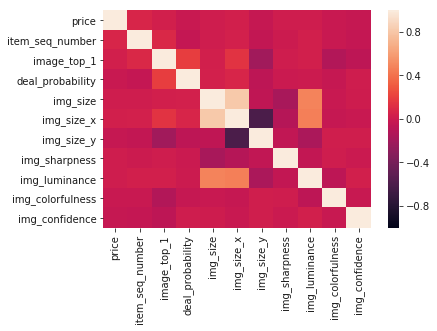

,price,item_seq_number,image_top_1,deal_probability,img_size,img_size_x,img_size_y,img_sharpness,img_luminance,img_colorfulness,img_confidence
price,1.000000,0.072826,0.034404,-0.010236,0.020799,0.034808,-0.031138,0.016073,0.018459,-0.013154,-0.024414
item_seq_number,0.072826,1.000000,0.091472,-0.034503,0.021885,0.044509,-0.045293,0.006091,0.033938,-0.015147,-0.031336
image_top_1,0.034404,0.091472,1.000000,0.189980,0.036051,0.141361,-0.196461,0.017585,0.035619,-0.117675,-0.067804
deal_probability,-0.010236,-0.034503,0.189980,1.000000,0.041572,0.071471,-0.069030,-0.003063,0.001859,-0.029725,0.019534
img_size,0.020799,0.021885,0.036051,0.041572,1.000000,0.818259,-0.058088,-0.165930,0.482875,-0.014269,0.012540
img_size_x,0.034808,0.044509,0.141361,0.071471,0.818259,1.000000,-0.606438,-0.107849,0.465222,-0.029740,-0.009386
img_size_y,-0.031138,-0.045293,-0.196461,-0.069030,-0.058088,-0.606438,1.000000,-0.054517,-0.151259,0.031187,0.028382
img_sharpness,0.016073,0.006091,0.017585,-0.003063,-0.165930,-0.107849,-0.054517,1.000000,-0.042285,0.020408,-0.005656
img_luminance,0.018459,0.033938,0.035619,0.001859,0.482875,0.465222,-0.151259,-0.042285,1.000000,-0.068284,0.035117
img_colorfulness,-0.013154,-0.015147,-0.117675,-0.029725,-0.014269,-0.029740,0.031187,0.020408,-0.068284,1.000000,-0.016455


In [14]:
print('Pearson correlation:')
corr = merged_train_with_features.corr()
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

Spearman correlation:


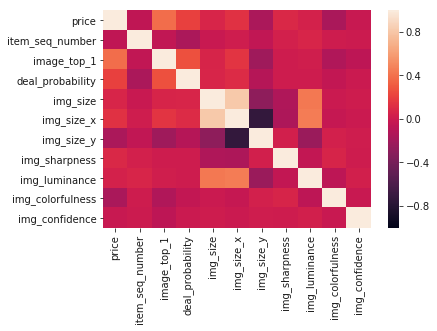

,price,item_seq_number,image_top_1,deal_probability,img_size,img_size_x,img_size_y,img_sharpness,img_luminance,img_colorfulness,img_confidence
price,1.000000,-0.059745,0.389689,0.207264,0.073682,0.134412,-0.151470,0.086962,0.053879,-0.161992,-0.018374
item_seq_number,-0.059745,1.000000,-0.047572,-0.152494,-0.014327,0.019834,-0.052952,0.044973,0.078075,0.012934,0.004151
image_top_1,0.389689,-0.047572,1.000000,0.267342,0.063341,0.153759,-0.207251,0.013912,0.030809,-0.127570,-0.069810
deal_probability,0.207264,-0.152494,0.267342,1.000000,0.071574,0.104172,-0.102842,0.013675,0.013522,-0.044795,-0.003493
img_size,0.073682,-0.014327,0.063341,0.071574,1.000000,0.819097,-0.282589,-0.137940,0.436988,-0.005342,0.008350
img_size_x,0.134412,0.019834,0.153759,0.104172,0.819097,1.000000,-0.731128,-0.141466,0.445700,-0.025061,-0.003829
img_size_y,-0.151470,-0.052952,-0.207251,-0.102842,-0.282589,-0.731128,1.000000,0.038684,-0.227776,0.041086,0.022469
img_sharpness,0.086962,0.044973,0.013912,0.013675,-0.137940,-0.141466,0.038684,1.000000,-0.041667,0.069515,0.008561
img_luminance,0.053879,0.078075,0.030809,0.013522,0.436988,0.445700,-0.227776,-0.041667,1.000000,-0.069877,0.034222
img_colorfulness,-0.161992,0.012934,-0.127570,-0.044795,-0.005342,-0.025061,0.041086,0.069515,-0.069877,1.000000,-0.014977


In [15]:
print('Spearman correlation:')
corr = merged_train_with_features.corr('spearman')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

Kendal-tau correlation:


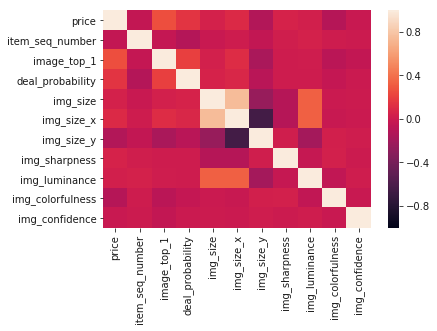

,price,item_seq_number,image_top_1,deal_probability,img_size,img_size_x,img_size_y,img_sharpness,img_luminance,img_colorfulness,img_confidence
price,1.000000,-0.044448,0.265315,0.153782,0.054233,0.098398,-0.121336,0.059399,0.035961,-0.109067,-0.012323
item_seq_number,-0.044448,1.000000,-0.033333,-0.113053,-0.010662,0.014817,-0.042166,0.030190,0.052536,0.009003,0.002834
image_top_1,0.265315,-0.033333,1.000000,0.200737,0.045969,0.110518,-0.163979,0.009479,0.020735,-0.085509,-0.046194
deal_probability,0.153782,-0.113053,0.200737,1.000000,0.059105,0.084620,-0.091604,0.010233,0.010141,-0.033657,-0.002648
img_size,0.054233,-0.010662,0.045969,0.059105,1.000000,0.756897,-0.248513,-0.102285,0.334574,-0.004107,0.006104
img_size_x,0.098398,0.014817,0.110518,0.084620,0.756897,1.000000,-0.644880,-0.103015,0.334545,-0.018090,-0.002760
img_size_y,-0.121336,-0.042166,-0.163979,-0.091604,-0.248513,-0.644880,1.000000,0.031245,-0.182889,0.032461,0.017726
img_sharpness,0.059399,0.030190,0.009479,0.010233,-0.102285,-0.103015,0.031245,1.000000,-0.027897,0.046489,0.005718
img_luminance,0.035961,0.052536,0.020735,0.010141,0.334574,0.334545,-0.182889,-0.027897,1.000000,-0.046977,0.022893
img_colorfulness,-0.109067,0.009003,-0.085509,-0.033657,-0.004107,-0.018090,0.032461,0.046489,-0.046977,1.000000,-0.010003


In [16]:
print('Kendal-tau correlation:')
corr = merged_train_with_features.corr('kendall')
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

From these correlations, we can see that 'image_top_1' and 'price' is most correlated to 'img_size_y' and 'img_colorfulness'.

Maybe the Power Users, which have the highest deal probability, can tell something:

In [17]:
power_users = merged_train_with_features[(merged_train_with_features.deal_probability >= 0.5)]

Pearson correlation:


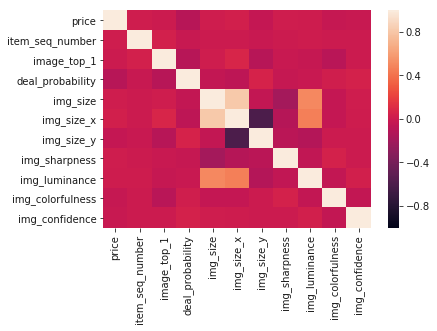

,price,item_seq_number,image_top_1,deal_probability,img_size,img_size_x,img_size_y,img_sharpness,img_luminance,img_colorfulness,img_confidence
price,1.000000,0.016362,0.006559,-0.095870,0.020009,0.035053,-0.035731,0.021469,0.011643,-0.030645,-0.016247
item_seq_number,0.016362,1.000000,0.044354,-0.018709,0.001564,0.007302,-0.009849,0.003282,0.010168,0.003333,0.005612
image_top_1,0.006559,0.044354,1.000000,-0.101528,0.020920,0.072617,-0.096831,-0.013889,-0.030952,-0.085996,0.003020
deal_probability,-0.095870,-0.018709,-0.101528,1.000000,-0.041534,-0.064760,0.055602,-0.030149,-0.008495,0.028184,0.049894
img_size,0.020009,0.001564,0.020920,-0.041534,1.000000,0.815495,-0.042149,-0.180192,0.506251,-0.037377,0.022178
img_size_x,0.035053,0.007302,0.072617,-0.064760,0.815495,1.000000,-0.599380,-0.108193,0.465399,-0.032860,0.012015
img_size_y,-0.035731,-0.009849,-0.096831,0.055602,-0.042149,-0.599380,1.000000,-0.081160,-0.110471,0.003354,0.005400
img_sharpness,0.021469,0.003282,-0.013889,-0.030149,-0.180192,-0.108193,-0.081160,1.000000,-0.054199,0.047545,0.000326
img_luminance,0.011643,0.010168,-0.030952,-0.008495,0.506251,0.465399,-0.110471,-0.054199,1.000000,-0.043015,0.035804
img_colorfulness,-0.030645,0.003333,-0.085996,0.028184,-0.037377,-0.032860,0.003354,0.047545,-0.043015,1.000000,-0.044970


In [18]:
print('Pearson correlation:')
corr = power_users.corr()
sns.heatmap(corr,vmin = -1, vmax = 1, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()
display(corr)

Not at all...
***

## Conclusion

The images contain a lot of information in it. Naturally, the quality of the image should affect the deal probability of an ad. We tried to extract relevant features to measure the image quality and reflect that idea. Those features really indicated how much the image is sharp, clear and colorful. Although, we couldn't see any condfirmation about it in the data exploration. But, as we could see later by running some models feature importance, some of the image features were located high in the list. In addition, they improved our RMSE score in overall.
***